# Vigenère En/Decoder
#### By Ethan Sim

This is my second cryptography project after my Morse translator, and this time I'll be taking it slightly deeper. Beyond creating a GUI for the user to input their code, I also want to perform runtime analysis on two approaches (Basic and Memoized) to the Vigenère problem.

Broadly, our strategy will be to:
- Write encoding and decoding functions corresponding to our two approaches.
- Test both with a test suite.
- Create a timing function and use matplotlib to monitor the time taken by each function as input and key size vary, presenting this as graphs.
- Wrap our favourite function in a GUI using tkinter.

## How does Vigenère work?

You need two things - your plaintext and a key. You will encode the message letter by letter using **Figure 1**. Locate your first plaintext letter on the horizontal row, and your first key letter on the vertical column. Where they intersect gives you the first letter of your ciphertext. If your key is shorter than your message, repeat its letters as needed until you hit the full length of the message.

As an illustration (taken from Wikipedia): 
- Plaintext: ATTACKATDAWN
- Key: LEMON --> LEMONLEMONLE (I call this the "keystring")
- Ciphertext: LXFOPVEFRNHR

Try it yourself!

<img src="Vigenère_square_shading.svg">

**Figure 1: The basis of our Vigenère translation. Source: https://commons.wikimedia.org/wiki/File:Vigen%C3%A8re_square_shading.svg**

## The Basic Approach

We can see that we are, in effect, shifting each letter by its keystring counterpart's position in the alphabet. Note that because no shift occurs when our key is "a", our alphabet must be indexed from 0. And - from **Figure 1** - we note that if we shift a letter by "z", we hit the letter just before it! We can thus encode our message algebraically with the modulo operator.

To build our encoding and decoding functions, we first need a dictionary to convert letters to numbers. Unfortunately - like Morse - Vignère can't distinguish between upper and lowercase letters! So our plaintext and ciphertext will both be uppercased. Note that we will remove spaces later - we don't want people to guess our message easily!

In [4]:
alpha_num = {"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6, "H":7, "I":8, "J":9, "K":10, "L":11, "M":12, "N":13, 
             "O":14, "P":15, "Q":16, "R":17, "S":18, "T":19, "U":20, "V":21, "W":22, "X":23, "Y":24, "Z":25}

#Creating this list to save memory when looking up values
alphabet_list = list(alpha_num.keys())

First, let's create some helper functions - we know both encoding and decoding require keystring building, whitespace removal, and uppercasing.

In [134]:
#Helper function to prep plaintext, ciphertext and key for encoding, decoding and keystring building respectively

def message_prepper(message):
    """
    Takes in a string message, and returns a string message_copy, which has no whitespace and is all uppercase.
    """
    message_copy = str(message)
    message_copy = message_copy.replace(" ","") #If we want to preserve spaces, we can add a Boolean flag (but we must strip spaces for keys)
    #Strip punctuation
    message_copy = message_copy.replace("(","").replace(")", "").replace(".", "").replace(",","").replace("'", "").replace('"', "").replace("?", "").replace(":", "").replace("-", "")
    message_copy = message_copy.upper()
    return message_copy         

#Helper function to build a keystring 

def keystring_builder(key, message_length):
    """
    Takes as input a string key and integer message_length, and returns a string keystring.
    """   
    #We need to remove any whitespace from the key
    key_copy = message_prepper(key)    
    #Depending on the length of the plaintext, build the keystring accordingly
    if len(key_copy) > message_length:
        keystring = key_copy[:message_length]
    elif len(key_copy) == message_length:
        keystring = str(key_copy) 
    else:
        keystring = str(key_copy) #Don't mutate the input
        key_letter = 0 
        for letter_idx in range(message_length - len(key_copy)): #This is the number of letters you need to add to make the keystring the same length as the plaintext
            keystring += key_copy[key_letter % len(key_copy)] #As we iterate through the characters, this will go from 0 to len(key) - 1, and back to 0, allowing us to generate our keystring
            key_letter += 1
    return keystring.upper()

With that out of the way, let's build our basic encoder and decoder.

In [6]:
#Basic Vigenère encoder - I got rid of the accent for ease of calling

def basic_vigenere_encoder(plaintext, key):
    """
    Takes two strings, plaintext and key, as input, encodes them via the Vigenère method, and returns a string ciphertext.
    """
    #Sanity checks
    if not (isinstance(plaintext, str) and isinstance(key, str)):
        return "Input two strings, plaintext and key"
    if len(key) == 0: #No key means no encoding
        return message_prepper(plaintext)
    
    #Prepare plaintext for encoding
    plaintext_copy = message_prepper(plaintext)
    
    #Prepare keystring for encoding - remember that keystring length is determined by plaintext length sans spaces
    keystring = keystring_builder(key, len(plaintext_copy))
    
    #Initialise a pointer which runs across both plaintext_copy and keystring, and encode accordingly
    ciphertext = "" #Deals with empty plaintext strings
    for idx in range(len(plaintext_copy)):
        if plaintext_copy[idx] not in alphabet_list:
            return "ERROR: You can't encode this character: " + plaintext_copy[idx] + "\nYour encoded message thus far is: " + ciphertext
        elif keystring[idx] not in alphabet_list:
            return "ERROR: You can't use this character in your key: " + keystring[idx] + "\nYour encoded message thus far is: " + ciphertext
        else:
            ciphertext_letter_code = (alpha_num[plaintext_copy[idx]] + alpha_num[keystring[idx]]) % 26 #We convert the corresponding letters to numbers and solve for the ciphertext
            #This assumes you are using the English alphabet (26 characters) - consider (Z + A) % 26 = Z, and so on.
            ciphertext += alphabet_list[ciphertext_letter_code] 
    return ciphertext

#Basic Vigenère decoder

def basic_vigenere_decoder(ciphertext, key):
    """
    Takes two strings, ciphertext and key, as input, decodes them via the Vigenère method, and returns a string plaintext.
    """
    #Sanity checks
    if not (isinstance(ciphertext, str) and isinstance(key, str)):
        return "Input two strings, ciphertext and key"
    if len(key) == 0: #No key means no decoding
        return message_prepper(ciphertext)
    
    #Prepare ciphertext for decoding
    ciphertext_copy = message_prepper(ciphertext)
    
    #Prepare keystring for decoding
    keystring = keystring_builder(key, len(ciphertext_copy))
    
    #Initialise a pointer which runs across both ciphertext_copy and keystring, and decode accordingly
    plaintext = ""
    for idx in range(len(ciphertext_copy)):
        if ciphertext_copy[idx] not in alphabet_list:
            return "ERROR: I can't decode this character: " + ciphertext_copy[idx] + "\nYour decoded message thus far is: " + plaintext
        elif keystring[idx] not in alphabet_list:
            return "ERROR: You can't use this character in your key: " + keystring[idx] + "\nYour decoded message thus far is: " + plaintext
        else:
            plaintext_letter_code = (alpha_num[ciphertext_copy[idx]] - alpha_num[keystring[idx]]) % 26
            plaintext += alphabet_list[plaintext_letter_code]
    return plaintext

Evidently, the structure of the encoder and decoder are very similar. Surely there's a way for us to make a single function which does both? Let's use dictionary refactoring!

In [7]:
#First, initialise our encoder and decoder dictionaries - we use this because it's faster to look stuff up in a dictionary - and we will be doing a lot of looking.

encoder_dict = {0:"Plaintext", 1:"encode", 2:"encoded", 3:1}

decoder_dict = {0:"Ciphertext", 1:"decode", 2:"decoded", 3:-1}

#Second, initialise our master dictionary, flag_dict - this will point to both dictionaries above.

flag_dict = {"encode":encoder_dict, "decode":decoder_dict}

#Let's combine both functions into one, using the generic name "message" to replace ciphertext and plaintext.

def basic_vigenere_translator(message, key, flag):
    """
    Takes as input three strings, message, key, and flag, encodes or decodes via the Vigenère method depending on flag, and returns a string output.
    """
    #Sanity checks
    if flag != "encode" and flag != "decode":
        return "ERROR: Flag must either be 'encode' or 'decode'!"
    elif not isinstance(message, str):
        return "ERROR: " + flag_dict[flag][0] + " must be a string!"
    elif not isinstance(key, str):
        return "ERROR: Key must be a string!"
    elif len(key) == 0: #No key means no encoding or decoding
        return message_prepper(message)
    
    #Prepare message for encoding or decoding
    message_copy = message_prepper(message)
    
    #Prepare keystring for encoding or decoding
    keystring = keystring_builder(key, len(message_copy))
    
    #Initialise a pointer which runs across both message_copy and keystring, and encode or decode accordingly
    output = ""
    for idx in range(len(message_copy)):
        if message_copy[idx] not in alphabet_list:
            return "ERROR: I can't " + flag_dict[flag][1] + " this character: " + message_copy[idx] + "\nYour " + flag_dict[flag][2] + " message thus far is: " + output
        elif keystring[idx] not in alphabet_list:
            return "ERROR: You can't use this character in your key: " + keystring[idx] + "\nYour " + flag_dict[flag][2] + " message thus far is: " + output
        else:
            output_letter_code = (alpha_num[message_copy[idx]] + alpha_num[keystring[idx]] * flag_dict[flag][3]) % 26
            output += alphabet_list[output_letter_code]
    return output

Now, it's time to test our basic translator. Do note that this testing suite will also be employed to assess our other methods as well. We'll compare our outputs to those from https://www.dcode.fr/vigenere-cipher.

In [8]:
def test_vigenere(translator_function):
    """
    This will run our Vigenère translator (translator_function) against a selection of varying inputs, and compare the outputs to a model answer.
    """
    
    #Assess edge cases first - Indeed this means all our functions will have the same error messages for the same edge case.
    assert translator_function("","","") == "ERROR: Flag must either be 'encode' or 'decode'!", "Test 1 failed: input '', '', ''"
    assert translator_function(123, "", "encode") == "ERROR: Plaintext must be a string!", "Test 2 failed: input 123, '', 'encode'"
    assert translator_function("", 123, "encode") == "ERROR: Key must be a string!", "Test 3 failed: input '', 123, 'encode'"
    assert translator_function("test", "", "encode") == "TEST", "Test 4 failed: input 'test', '', 'encode'"
    assert translator_function("", "testkey", "encode") == "", "Test 5 failed: input '', 'testkey', 'encode'"
    assert translator_function(123, "", "decode") == "ERROR: Ciphertext must be a string!", "Test 6 failed: input 123, '', 'decode'"
    assert translator_function("fake_plaintext", "testkey", "encode") == "ERROR: I can't encode this character: _\nYour encoded message thus far is: YECX", "Test 7 failed: input 'fake_plaintext', 'testkey', 'encode'"
    assert translator_function("fake_plaintext", "f@kekey", "encode") == "ERROR: You can't use this character in your key: @\nYour encoded message thus far is: K", "Test 8 failed: input 'fake_plaintext', 'f@kekey', 'encode'"
    assert translator_function("fake_plaintext", "testkey", "decode") == "ERROR: I can't decode this character: _\nYour decoded message thus far is: MWSL", "Test 9 failed: input 'fake_plaintext', 'testkey', 'decode'"
    assert translator_function("fake_plaintext", "f@kekey", "decode") == "ERROR: You can't use this character in your key: @\nYour decoded message thus far is: A", "Test 10 failed: input 'fake_plaintext', 'f@kekey', 'decode'"
   
    #Assess encoding and decoding capability
    assert translator_function("This is a test message", "test key", "encode") == "MLALSWYMIKMWIQLEYX", "Test 11 failed: input 'This is a test message', 'test key', 'encode'"
    assert translator_function("MLALSWYMIKMWIQLEYX", "test key", "decode") == "THISISATESTMESSAGE", "Test 12 failed: input 'MLALSWYMIKMWIQLEYX', 'test key', 'decode'"
    
    print("Congratulations! 12/12 tests passed!")
    
test_vigenere(basic_vigenere_translator)

Congratulations! 12/12 tests passed!


We finally have a working Vigenère translator, but is this the only way we can create one?

## The Memoized Approach

This will be a teeny modification to the code, which (I predict) will probably only make a difference when the message is substantially longer and more complex than the key. Essentially, we want to store the result of previous input character-key character modifications in a dictionary. If this combination is encountered again, rather than looking up dictionaries 3 times, this will look up that dictionary only once. 

In [21]:
#Let's make some modifications to our basic translator, using the same dictionaries to refactor it

def memoized_vigenere_translator(message, key, flag):
    """
    Takes as input three strings, message, key, and flag, encodes or decodes via a memoized Vigenère method depending on flag, and returns a string output.
    """
    #Sanity checks
    if flag != "encode" and flag != "decode":
        return "ERROR: Flag must either be 'encode' or 'decode'!"
    elif not isinstance(message, str):
        return "ERROR: " + flag_dict[flag][0] + " must be a string!"
    elif not isinstance(key, str):
        return "ERROR: Key must be a string!"
    elif len(key) == 0: #No key means no encoding or decoding
        return message_prepper(message)
    
    #Initialise an empty local dictionary - each message-keystring combination is assumed to be unique per function run
    local_vigenere_dict = {}
    
    #Prepare message for encoding or decoding
    message_copy = message_prepper(message)
    
    #Prepare keystring for encoding or decoding
    keystring = keystring_builder(key, len(message_copy))
    
    #Initialise a pointer which runs across both message_copy and keystring, and encode or decode accordingly
    output = ""
    for idx in range(len(message_copy)):
        if message_copy[idx] not in alphabet_list:
            return "ERROR: I can't " + flag_dict[flag][1] + " this character: " + message_copy[idx] + "\nYour " + flag_dict[flag][2] + " message thus far is: " + output
        elif keystring[idx] not in alphabet_list:
            return "ERROR: You can't use this character in your key: " + keystring[idx] + "\nYour " + flag_dict[flag][2] + " message thus far is: " + output
        else:
            #If not previously encountered, decode and write it in the dictionary
            if (message_copy[idx], keystring[idx]) not in local_vigenere_dict.keys():
                output_letter_code = (alpha_num[message_copy[idx]] + alpha_num[keystring[idx]] * flag_dict[flag][3]) % 26
                output += alphabet_list[output_letter_code]
                local_vigenere_dict[(message_copy[idx], keystring[idx])] = alphabet_list[output_letter_code]
            else:
            #If previously encountered, just look it up and concatenate
                output += local_vigenere_dict[(message_copy[idx], keystring[idx])]
    return output

And of course, let's test it.

In [22]:
test_vigenere(memoized_vigenere_translator)

Congratulations! 12/12 tests passed!


## Runtime Analysis

If two things can perform the same function, how do we know which one is better, and under which circumstances? Specifically, knowing that memoization is expected to reap returns only if common subproblems are repeatedly encountered, to what extent will memoization make our Vigenère translation more efficient?

We need to design an experiment which will enable us to compare the two functions on equal footing - the only thing that should vary is the size of the inputs (message and/or key). Our strategy will be as follows:
- Randomly generate a list of inputs ranging from size = 1 to size = 10,000
- Randomly generate a list of keys ranging from size = 1 to size = 10,000
- Using a simple timing function, determine the time taken for both functions to encode varying inputs for a given key, and varying key lengths for a given input, and plot accordingly.

Let's start by generating our random lists:

In [48]:
import random

def input_generator(number):
    """
    Randomly generates a list of strings with lengths 1 to number, using the English alphabet.
    """
    string_list = [random.choice(alphabet_list)]
    for string_length in range(1, number):
        string_list.append(string_list[string_length - 1] + random.choice(alphabet_list))
    return string_list
   
message_list = input_generator(10000)
key_list = input_generator(10000)

Now, let's determine the time taken for each function to resolve varying message sizes using a given key. We'll use an arbitrarily determined key (THISISATESTKEY) for this exercise. I hypothesise that memoization should perform much faster as relative size of the message (compared to the key) increases.

In [57]:
from time import time

def expt_one_timer(translator_function, key, sample_size):
    """
    Runs translator_function on a number (sample_size) of messages of increasing length, with the string key. Returns a list of times taken to process each message.
    """
    #Sanity checks
    if not isinstance(key, str):
        return "ERROR: Key must be a string!"
    elif len(key) == 0: 
        return "ERROR: No key given - experiment cannot be performed!"
    elif not isinstance(sample_size, int):
        return "ERROR: Sample size must be an integer!"
    
    output_list = [] #This will deal with sample_size = 0 edge cases.
    for idx in range(0, sample_size):
        time_one = time()
        translator_function(message_list[idx], key, "encode")
        time_two = time()
        time_taken = time_two - time_one
        output_list.append(time_taken)
    return output_list

Now, let's generate the data proper (and our x-axis).

In [59]:
# Data for plotting
basic_data_one = expt_one_timer(basic_vigenere_translator, 'THISISATESTKEY', 10000)
memoized_data_one = expt_one_timer(memoized_vigenere_translator, 'THISISATESTKEY', 10000)

x_axis = []
for num in range(1,10001):
    x_axis.append(num)

With this in hand, let's start plotting. This was prepared with instruction from https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php.

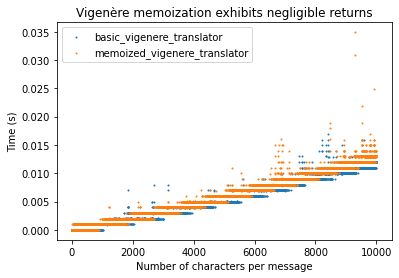

In [96]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(x_axis, basic_data_one, s = 1, label = "basic_vigenere_translator")
plt.scatter(x_axis, memoized_data_one, s = 1, label = "memoized_vigenere_translator")

plt.xlabel("Number of characters per message")
plt.ylabel("Time (s)")
plt.title("Vigenère memoization exhibits negligible returns")
plt.legend()
plt.savefig("fig_one.png")
plt.show()

Now this is pretty strange, isn't it? What if we kept input size constant - using the same 10,000 character message - and varied key size? Would we then get the same picture? Note that these are two different sets of data, with different relative complexities!

In [66]:
def expt_two_timer(translator_function, message, sample_size):
    """
    Runs translator_function on a number (sample_size) of keys of increasing length, against the string message. Returns a list of times taken to process the message with a given key.
    """
    #Sanity checks
    if not isinstance(message, str):
        return "ERROR: Message must be a string!"
    elif len(message) == 0: 
        return "ERROR: No message given - experiment cannot be performed!"
    elif not isinstance(sample_size, int):
        return "ERROR: Sample size must be an integer!"
    
    output_list = [] #This will deal with sample_size = 0 edge cases.
    for idx in range(0, sample_size):
        time_one = time()
        translator_function(message, key_list[idx], "encode")
        time_two = time()
        time_taken = time_two - time_one
        output_list.append(time_taken)
    return output_list

Once again, we generate our data.

In [70]:
# Data for plotting
basic_data_two = expt_two_timer(basic_vigenere_translator, message_list[-1], 10000)
memoized_data_two = expt_two_timer(memoized_vigenere_translator, message_list[-1], 10000)

And plot.

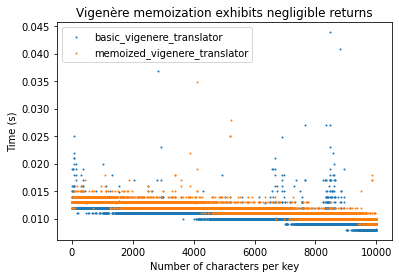

In [105]:
plt.scatter(x_axis, basic_data_two, s = 1, label = "basic_vigenere_translator")
plt.scatter(x_axis, memoized_data_two, s = 1, label = "memoized_vigenere_translator")

plt.xlabel("Number of characters per key")
plt.ylabel("Time (s)")
plt.title("Vigenère memoization exhibits negligible returns")
plt.legend()
plt.savefig("fig_two.png")
plt.show()

#I believe the time decreases because keystring_builder() takes less time to run as the size of the key increases relative to the message.

## Discussion

Dynamic programming is conventionally held to reduce time complexity by storing subproblem solutions, but it only reaps significant returns if the same subproblems are repeatedly encountered. How can we determine if the same subproblems are repeatedly encountered here?

Knowing that our first experiment essentially swotted 10,000 messages (which were all dependent, rather than independent) against one key, and that our second experiment swotted 10,000 keys - again all dependent - against a message 10,000 characters long, we can use sets to determine the number of repeated message-key pairs in the worst-case scenario. This is because sets reject duplicates.

In [102]:
def unique_ident(message, key):
    """
    Takes in two strings, message and key, and returns the number of unique message-key character pairs.
    """
    #We won't bother with sanity checks here - this is purely analytical rather than for the user end.
    output_set = set([])
    keystring = keystring_builder(key, len(message))
    for idx in range(1, len(message)):
        output_set.add((message[idx], keystring[idx]))
    return len(output_set)

In [104]:
print (unique_ident(message_list[-1], "THISISATESTKEY")) #Number of unique pairs in Experiment 1
print (unique_ident(message_list[-1], key_list[-1])) #Number of unique pairs in Experiment 2

208
676


So we should be seeing the same subproblem on average, well, 10,000 / 208 = 48 times for the first experiment, and 10,000 / 676 = 15 times for the second experiment. Then why isn't memoization much faster than the basic method?

Let's examine the hypothesis that our dataset might be limited. Perhaps memoization does have an effect, but even 10,000 characters might be too small for us to see it. Let's expand our dataset to 100,000 characters and see what happens!

In [107]:
def dataset_expander(string):
    """
    Takes in a string string, and returns a list of string copies ranging from 1x its length to 10x its length.
    """
    output_list = [string]
    for list_index in range(1,10):
        output_list.append(output_list[list_index - 1] + string)
    return output_list

In [108]:
expanded_message_list = dataset_expander(message_list[-1])
expanded_key_list = dataset_expander(key_list[-1])

In [109]:
def expt_three_timer(translator_function, message_list, key_list):
    """
    Runs translator_function on messages and keys of increasing length, from message_list and key_list (both ordered and of the same length) respectively. 
    Returns a list of times taken to process each message and its corresponding key of the same length.
    """
    #Skip the sanity checks for now
    
    output_list = [] 
    for idx in range(0, len(message_list)):
        time_one = time()
        translator_function(message_list[idx], key_list[idx], "encode")
        time_two = time()
        time_taken = time_two - time_one
        output_list.append(time_taken)
    return output_list

In [119]:
basic_data_three = expt_three_timer(basic_vigenere_translator, expanded_message_list, expanded_key_list)
memoized_data_three = expt_three_timer(memoized_vigenere_translator, expanded_message_list, expanded_key_list)

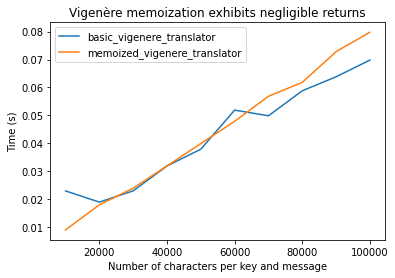

In [120]:
x_axis_expt_three = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

plt.plot(x_axis_expt_three, basic_data_three, label = "basic_vigenere_translator")
plt.plot(x_axis_expt_three, memoized_data_three, label = "memoized_vigenere_translator")

plt.xlabel("Number of characters per key and message")
plt.ylabel("Time (s)")
plt.title("Vigenère memoization exhibits negligible returns")
plt.legend()
plt.savefig("fig_three.png")
plt.show()

Clearly, it's not the dataset that's limited. There must be something intrinsic to my implementation of memoization which leads to slightly greater time complexity.

Let's use big-O notation to determine the (relative) time complexity of both memoization and the basic approach. If we only consider the areas in which they differ, the basic apporach has time complexity of O(n), where n is the length of the message. This is because each character of the message is compared to each character of the keystring, and a result arrived at. Conversely, the memoized approach has time complexity of O(n) * O(m), where m is the size of the list traversed to determine whether a particular message-key character combination has been encountered before. Actually, m = 676 (26^2) when inputs get large, and although this is negligible, it might explain the very slight increase observed.

## A Reflective Conclusion

I hate to admit it, but a little knowledge is a dangerous thing. At the start of this exercise, I believed that any approach which stored and reused values would save the computer the effort of calculating them afresh, and lead to reduced time complexity. Yet, when deciding whether to memoize, one must also consider the structure of the problem encountered. It is not simply about encountering repeated subproblems; it is also about encountering repeated subproblems which _build upon each other_. 

To use an analogy, the value of the 13 times table is that it is difficult to arrive at 13 * 9 without first going through the lower multiples, or back-calculating from 13 * 10. Memorising (memoizing) this times table allows you to throw out that answer (117) without performing those operations first. A 1 times table, on the other hand, is pretty much useless - there is no benefit to storing values because calculating the solutions to new problems which involve multiplication by 1 takes around the same effort as recalling it.

Bringing us back to this problem, let us compare the subproblem structure of the Fibonacci problem (https://algorithms.tutorialhorizon.com/introduction-to-dynamic-programming-fibonacci-series/) to this Vigenère question. Each new Fibonacci number requires the solutions of previous Fibonacci numbers to be calculated before it can be arrived at, and memoization cuts out all of this work, reducing a time complexity of O(2^n) to O(n), where n Fibonacci numbers are calculated. That is to say, unlike the navive recursive approach where smaller Fibonacci numbers are repeatedly calculated afresh, in the memoized approach, each Fibonacci number is only calculated once. Yet, in this Vigenère problem, each new message-key character combination can be calculated in one step, and no constituent subproblems need to be solved to arrive at this step. Memoization thus doesn't simplify the task at all, and just wastes space! Unfortunately, it took me three runtime analyses and a whole Jupyter workbook to learn this.

## Final Steps: GUI creation with tkinter

The bulk of this code is from the Morse translator - with a few modifications.

In [135]:
import tkinter
from tkinter import * #This gives us direct access to all public names within tkinter without needing to call tkinter.this, tkinter.that, etc.

vig_gui = Tk() #Initialises our GUI window - its name is vig_gui
vig_gui.title('Vigenère Translator') #Changes title

##First, we need some welcome text so the user knows what this is and what to do.

welcome_text = Text(vig_gui, height = 2, width = 100) #This is our text box
welcome_text.pack(side = TOP) #Our welcome text will be at the top of the window
welcome_text.insert("1.0","Welcome to my Vigenère Translator!\nSelect either Encode or Decode, put your message and key in, and hit Translate!") #Inserts at the first character (0) of the first line (1)

##Our translator function does two mutually exclusive things, so we need mutually exclusive options - radio buttons will work best.

de_en_flag = StringVar() #Tell tkinter what type of variable this is: a StringVar object is a container which takes in strings
de_en_flag.set("encode") #We set this variable to have the value "encode" first, so we don't inadvertently fill both radio buttons - comment this out to see what I mean
Radiobutton(vig_gui, text = "Encode", variable = de_en_flag, value = "encode").pack(anchor = N, pady = (10,0)) #By clicking on the button, we change the value of de_en_flag
Radiobutton(vig_gui, text = "Decode", variable = de_en_flag, value = "decode").pack(anchor = N, pady = (0,10)) #Anchor controls where the text is postioned within morse_gui - options are N, NW, etc. and CENTER.
#The pady option takes in either a single integer or a tuple - adds the specified amount of vertical space to the top and bottom.

##After selecting their option, the user needs to know where to put their message in.

input_text_msg = Text(vig_gui, height = 1, width = 23)
input_text_msg.pack(side = TOP)
input_text_msg.insert("1.0", "Put your message below!")

##We then create the space in which the user can put their message in.

user_input_message = Entry(vig_gui, width = 100)
user_input_message.pack(side = TOP, pady = 15)

##Skip this for now --------- (1)

#After repeated usage, I needed some way to quickly remove large messages, given the limited size of the user input box.

def clear_message():
    user_input_message.delete(0, END) #Clears user input box

clear_button_msg = Button(vig_gui, text = 'Clear Message', width = 25, command = clear_message)
clear_button_msg.pack(side = TOP, pady = (0,15))

##The user also needs to know where to put their key in.

input_text_key = Text(vig_gui, height = 1, width = 19)
input_text_key.pack(side = TOP)
input_text_key.insert("1.0", "Put your key below!")

##We then create the space in which the user can put their key in.

user_input_key = Entry(vig_gui, width = 100)
user_input_key.pack(side = TOP, pady = 15)

##Now, we need to find some way of initiating the encoding or decoding process. 

def start_translator(de_en_flag): #This allows us to create conditional additions to the GUI
    if de_en_flag == "encode":
        output_text.replace("1.0", END, basic_vigenere_translator(user_input_message.get(), user_input_key.get(), de_en_flag)) #Removes all characters in the box (from 1.0 to the end) and puts the specified string in
    elif de_en_flag == "decode":
        output_text.replace("1.0", END, basic_vigenere_translator(user_input_message.get(), user_input_key.get(), de_en_flag))
#Note that output_text (where the output will be displayed) has not been defined yet - this is okay, because the function has not yet been called.

##Skip this for now --------- (3)

#Aesthetically, I wanted to put the buttons below the key input box side-by-side, in the centre.
#The best solution for this was to create a frame to hold them both, and position that frame between the user input and the output. This is where "code echoes order" helps a lot.
        
main_frame = Frame(vig_gui)
main_frame.pack(side = TOP)

##Now we need to let the user call start_translator. We need a start button.

start_button = Button(vig_gui, text = 'Translate!', width = 25, command = lambda: start_translator(de_en_flag.get())) 
#This lambda will use the StringVar object's get() method to return its current value, then pass it to start_translator
start_button.pack(in_ = main_frame, side = LEFT)

##Skip this for now --------- (2)

#After repeated usage, I needed some way to quickly remove large keys, given the limited size of the user input box.

def clear_key():
    user_input_key.delete(0, END) #Clears key input box

clear_button_key = Button(vig_gui, text = 'Clear Key', width = 25, command = clear_key)
clear_button_key.pack(in_ = main_frame, side = RIGHT, padx = (20,0))

##We then need to display the output to the user.

output_text = Text(vig_gui, height = 10, width = 100)
output_text.pack(side = TOP, pady = 15)

##Finally, we need some way of neatly exiting the window.

exit_button = Button(vig_gui, text='Exit', width=25, command=vig_gui.destroy) #Adds exit button to terminate gui
exit_button.pack(side = TOP, pady = (0,15)) #Our exit button will be on the bottom of the window

##Once we're done, let's run the GUI!

vig_gui.mainloop() #This starts the GUI

## Go to points (1) and (2). 

## Go to point (3).